In [1]:
hp = {}
hp['dataset'] = 'imagenet-full'
hp['variant'] = 'artificial'
hp['max_size_for_area_under_roc_curve'] = float('inf')

In [2]:
import json
from sklearn.metrics import roc_auc_score
from sklearn.cluster import AgglomerativeClustering
from torchvision import datasets
from twosample import utils
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter
from twosample import utils
import os
import itertools
import sklearn
from matplotlib.ticker import MaxNLocator

In [3]:
matplotlib.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')
figure_path = 'figures/artificial'
utils.create_directory_if_not_exists(figure_path)

In [4]:
def run_evaluation(hp):
    experiment_directory = 'results/largescale/{}/'.format(hp['variant'])
    if hp['variant'] == 'artificial':
        experiment_directory += '{}_{:.2f}/'.format(hp['initial_clustering']['minimum_initial_cluster_size'],
                                                    hp['initial_clustering']['noise_ratio'])
    experiment_directory += hp['dataset']
    affinities_directory = experiment_directory + '/affinities'
    dataset = datasets.ImageFolder('./datasets/' + hp['dataset'])
    initial_clustering_filename = experiment_directory + '/initial_clustering.npy'
    print('Load initial clustering from', initial_clustering_filename)
    sample_indices_train, sample_indices_test = np.load(initial_clustering_filename).tolist()
    initial_clustering = [a + b for a, b in zip(sample_indices_train, sample_indices_test)]
    num_clusters = len(sample_indices_test)
    cluster_categories = [utils.get_majority_category(dataset, sample_indices)
                          for sample_indices in initial_clustering]
    
    # Compute for each pair of clusters whether they have the same category.
    same_category = np.expand_dims(np.array(cluster_categories), 0) != np.expand_dims(np.array(cluster_categories), 1)
    # Only use upper triangle and ignore diagonal.
    # Diagonal contains self-similarities and must thus be ignored.
    upper_triangle_without_diagonal = np.triu_indices(len(cluster_categories), 1)
    same_category = same_category[upper_triangle_without_diagonal]
    if len(same_category) > hp['max_size_for_area_under_roc_curve']:
        print('Subsampling for efficient AUROC calculation.')
        random_indices = np.random.choice(len(same_category), size=hp['max_size_for_area_under_roc_curve'])
        same_category = same_category[random_indices] 

    mean_arithmetic_means, area_under_roc_curve = [], []
    for affinities_filename in sorted(os.listdir(affinities_directory), key=lambda x: int(x.split('.')[0])):
        affinities = np.load(affinities_directory + '/' + affinities_filename)
        
        # Filter out the degenerate diagonal entries.
        affinities_clean = affinities[upper_triangle_without_diagonal]              
        if len(affinities_clean) > hp['max_size_for_area_under_roc_curve']:
            affinities_clean = affinities_clean[random_indices]
        
        # Compute Area under ROC Curve
        area_under_roc_curve.append(roc_auc_score(same_category, affinities_clean))
        
        # Compute Mean Arithmetic Mean
        mean_arithmetic_means.append(np.mean(affinities_clean))
        print(affinities_filename, 'AUROC:', area_under_roc_curve[-1],
              'mean arithmetic mean:', mean_arithmetic_means[-1])
    return mean_arithmetic_means, area_under_roc_curve

In [5]:
hp['initial_clustering'] = {}
results = {}
for noise_ratio in [0.3, 0.1, 0]:
    results[noise_ratio] = {}
    for minimum_initial_cluster_size in [50, 125, 200]:
        hp['initial_clustering']['minimum_initial_cluster_size'] = minimum_initial_cluster_size
        hp['initial_clustering']['noise_ratio'] = noise_ratio
        results[noise_ratio][minimum_initial_cluster_size] = run_evaluation(hp)

Load initial clustering from results/largescale/artificial/50_0.30/imagenet-full/initial_clustering.npy
1.npy AUROC: 0.5854664414270724 mean arithmetic mean: 0.52629423
2.npy AUROC: 0.6512108984210009 mean arithmetic mean: 0.5508276
3.npy AUROC: 0.7390507874093069 mean arithmetic mean: 0.5843231
4.npy AUROC: 0.8564095066350236 mean arithmetic mean: 0.64601433
5.npy AUROC: 0.9048394974820813 mean arithmetic mean: 0.6763851
6.npy AUROC: 0.9331877690535282 mean arithmetic mean: 0.6958368
7.npy AUROC: 0.9495556872913751 mean arithmetic mean: 0.7092239
8.npy AUROC: 0.9495556872913751 mean arithmetic mean: 0.7092239
9.npy AUROC: 0.9594410162703992 mean arithmetic mean: 0.71542007
10.npy AUROC: 0.9611210709893211 mean arithmetic mean: 0.7150768
11.npy AUROC: 0.9618138153371121 mean arithmetic mean: 0.71416646
12.npy AUROC: 0.9620320514103516 mean arithmetic mean: 0.7119266
13.npy AUROC: 0.9631097594494052 mean arithmetic mean: 0.7126636
14.npy AUROC: 0.9625757598841685 mean arithmetic mean: 0

10.npy AUROC: 0.999963298527734 mean arithmetic mean: 0.96572924
11.npy AUROC: 0.9999659839050874 mean arithmetic mean: 0.96726596
12.npy AUROC: 0.9999671151330733 mean arithmetic mean: 0.9672593
13.npy AUROC: 0.9999692125117513 mean arithmetic mean: 0.9681803
14.npy AUROC: 0.9999707185385612 mean arithmetic mean: 0.9676279
15.npy AUROC: 0.9999727956240825 mean arithmetic mean: 0.9682121
Load initial clustering from results/largescale/artificial/200_0.00/imagenet-full/initial_clustering.npy
1.npy AUROC: 0.9976595653090847 mean arithmetic mean: 0.8638045
2.npy AUROC: 0.9998007237629092 mean arithmetic mean: 0.93106437
3.npy AUROC: 0.9999199300770188 mean arithmetic mean: 0.9507144
4.npy AUROC: 0.9999561851282897 mean arithmetic mean: 0.9591681
5.npy AUROC: 0.999968227299019 mean arithmetic mean: 0.9639407
6.npy AUROC: 0.9999790674638332 mean arithmetic mean: 0.9697956
7.npy AUROC: 0.9999820244643444 mean arithmetic mean: 0.9703632
8.npy AUROC: 0.999982706992159 mean arithmetic mean: 0.9

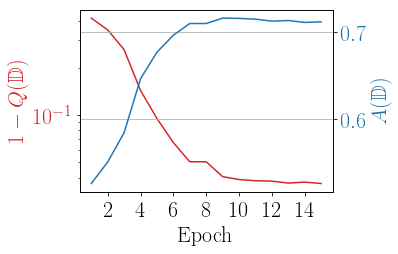

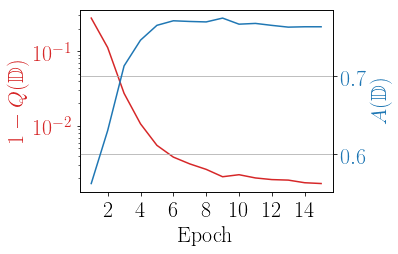

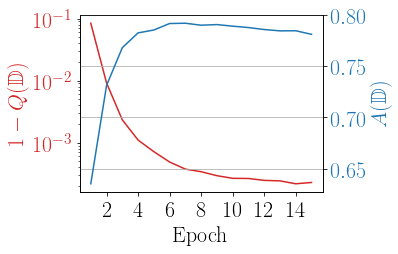

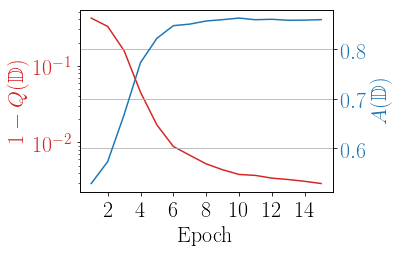

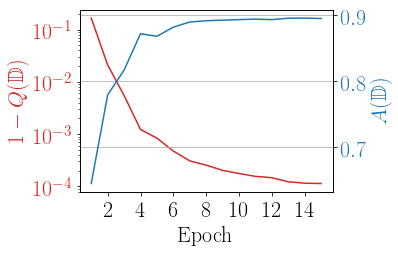

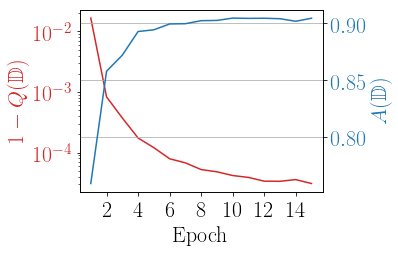

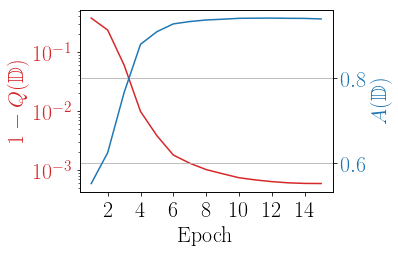

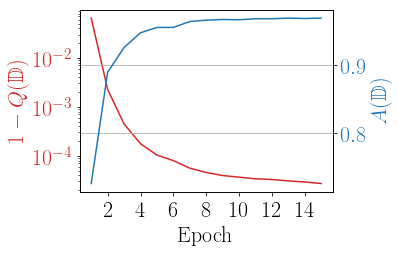

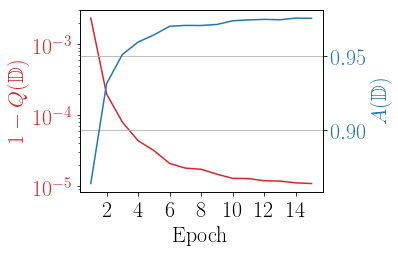

In [25]:
for noise_ratio in [0.3, 0.1, 0]:
    for minimum_initial_cluster_size in [50, 125, 200]:
        mean_arithmetic_means, area_under_roc_curve = results[noise_ratio][minimum_initial_cluster_size]
        area_under_roc_curve_trans = [1-x for x in area_under_roc_curve]
        epochs = np.arange(1, len(area_under_roc_curve) + 1)

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('$1 - Q(\mathbb{D})$', color=color)
        #ax1.plot(t, data1, color=color)
        ax1.semilogy(epochs, area_under_roc_curve_trans, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('$A(\mathbb{D})$', color=color)  # we already handled the x-label with ax1
        ax2.plot(epochs, mean_arithmetic_means, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.grid(True)
        figure_filename = figure_path + '/{}_{:.2f}.pdf'.format(
            minimum_initial_cluster_size,
            noise_ratio)
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.show()

1.44 2.54 3.23
2.77 3.94 4.57
3.64 4.51 4.96


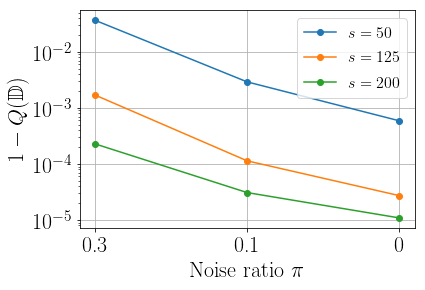

In [23]:
labels = []
for minimum_initial_cluster_size in [50, 125, 200]:
    labels.append('$s = {}$'.format(minimum_initial_cluster_size))
    noise_ratios = [0.3, 0.1, 0]
    area_under_roc_curve_trans = [1 - results[noise_ratio][minimum_initial_cluster_size][1][-1]
                                  for noise_ratio in noise_ratios]  
    print(' '.join(['{:.2f}'.format(x) for x in -np.log10(area_under_roc_curve_trans)]))
    plt.semilogy(np.arange(len(area_under_roc_curve_trans)), area_under_roc_curve_trans, 'o-')
    plt.grid(True)
    plt.xlabel('Noise ratio $\pi$')
    plt.ylabel('$1 - Q(\mathbb{D})$')
    ax = plt.gca()
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(labels, fontsize=16)
plt.xticks(np.arange(len(area_under_roc_curve_trans)), noise_ratios)
figure_filename = figure_path + '/q_combined.pdf'.format(
    minimum_initial_cluster_size,
    noise_ratio)
plt.savefig(figure_filename, bbox_inches='tight')
plt.show()

71.11% 85.94% 93.80%
76.36% 89.51% 96.82%
78.10% 90.45% 97.51%


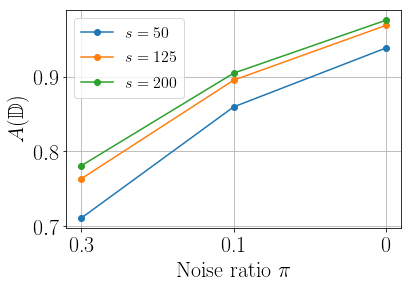

In [24]:
labels = []
for minimum_initial_cluster_size in [50, 125, 200]:
    labels.append('$s = {}$'.format(minimum_initial_cluster_size))
    noise_ratios = [0.3, 0.1, 0]
    mean_arithmetic_means = [results[noise_ratio][minimum_initial_cluster_size][0][-1]
                                  for noise_ratio in noise_ratios]
    print(' '.join(['{:.2f}%'.format(x*100) for x in mean_arithmetic_means]))
    plt.plot(np.arange(len(mean_arithmetic_means)), mean_arithmetic_means, 'o-')
    plt.grid(True)
    plt.xlabel('Noise ratio $\pi$')
    plt.ylabel('$A(\mathbb{D})$')
    ax = plt.gca()
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(labels, fontsize=16)
plt.xticks(np.arange(len(area_under_roc_curve_trans)), noise_ratios)
figure_filename = figure_path + '/a_combined.pdf'.format(
    minimum_initial_cluster_size,
    noise_ratio)
plt.savefig(figure_filename, bbox_inches='tight')
plt.show()